In [1]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import pyautogui
import screen_brightness_control as sbc
import pycaw.pycaw as pycaw
from comtypes import CLSCTX_ALL
from ctypes import cast, POINTER
import mediapipe as mp
from math import hypot
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import time
print("All libraries imported successfully!")

All libraries imported successfully!


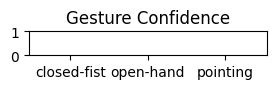

In [2]:
# Initialize audio control (for volume)
AudioUtilities = pycaw.AudioUtilities
IAudioEndpointVolume = pycaw.IAudioEndpointVolume
devices = AudioUtilities.GetSpeakers()
interface = devices.Activate(IAudioEndpointVolume._iid_, CLSCTX_ALL, None)
volume = cast(interface, POINTER(IAudioEndpointVolume))
volRange = volume.GetVolumeRange()
minVol, maxVol, _ = volRange

# Loading the trained CNN model
model = tf.keras.models.load_model('gesture_model_tuned.keras')  # Update if renamed to 'GMK-3.keras'

# Defining image dimensions for CNN (same as training)
IMG_HEIGHT = 64
IMG_WIDTH = 64

# Map predicted class to gesture name
class_indices = {'closed-fist': 0, 'open-hand': 1, 'pointing': 2}
gesture_names = {v: k for k, v in class_indices.items()}

# Initialize matplotlib figure for confidence bar
fig, ax = plt.subplots(figsize=(3, 1))
canvas = FigureCanvas(fig)
confidence_bars = ax.bar(list(gesture_names.values()), [0, 0, 0], color=['red', 'green', 'blue'])
ax.set_ylim(0, 1)
ax.set_title('Gesture Confidence')
plt.tight_layout()

def main():
    # Set up MediaPipe for hand tracking
    mpHands = mp.solutions.hands
    hands = mpHands.Hands(static_image_mode=False, max_num_hands=2, model_complexity=1, 
                         min_detection_confidence=0.5, min_tracking_confidence=0.5)
    draw = mp.solutions.drawing_utils

    # Initialize webcam
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Error: Could not open webcam.")
        exit()

    # Set up PyAutoGUI for mouse control
    pyautogui.FAILSAFE = True  # Move mouse to upper-left corner to abort
    pyautogui.PAUSE = 0.01  # Add a small delay between actions

    # Control variables
    frame_count = 0
    detection_count = 0
    brightness_values = []  # For stability
    distance_values = []   # For precision
    brightness_control_active = False
    volume_control_active = False
    mouse_control_active = False
    prev_gesture = None
    prediction_interval = 5  # Predict every 5 frames to reduce lag

    print("Starting real-time gesture control...")
    print("Use a plain white background for best results (as used in training).")
    print("Gestures:")
    print("- Open-hand (Left Hand): Enable brightness control (distance between index and thumb)")
    print("- Open-hand (Right Hand): Enable volume control (distance between index and thumb)")
    print("- Closed-fist: Disable brightness and volume control")
    print("- Pointing: Toggle mouse control (move cursor with hand)")
    print("Press 'Esc' to quit.")

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("Failed to capture frame.")
            break
        frame_count += 1

        # Flip the frame horizontally for a mirror effect
        frame = cv2.flip(frame, 1)

        # Process the frame with MediaPipe for hand tracking
        frameRGB = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        processed = hands.process(frameRGB)

        # Detect hands with MediaPipe
        if processed.multi_hand_landmarks:
            detection_count += 1
            print(f"Hands detected! Frame: {frame_count}, Detection: {detection_count}")
        else:
            print(f"No hands detected. Frame: {frame_count}, Detection: {detection_count}")

        # Get left and right hand landmarks
        left_landmark_list, right_landmark_list = get_left_right_landmarks(frame, processed, draw, mpHands)

        # Use CNN to predict gesture every few frames
        predicted_gesture = None
        confidence = 0
        if frame_count % prediction_interval == 0:
            # Draw a rectangle to indicate the region of interest (ROI) for the CNN
            height, width = frame.shape[:2]
            roi_size = 300  # Updated to 300x300 ROI
            roi_x = (width - roi_size) // 2
            roi_y = (height - roi_size) // 2
            cv2.rectangle(frame, (roi_x, roi_y), (roi_x + roi_size, roi_y + roi_size), (0, 255, 0), 2)

            # Extract the ROI for CNN prediction
            roi = frame[roi_y:roi_y + roi_size, roi_x:roi_x + roi_size]
            roi_resized = cv2.resize(roi, (IMG_HEIGHT, IMG_WIDTH))
            img_array = image.img_to_array(roi_resized)
            img_array = np.expand_dims(img_array, axis=0)
            img_array /= 255.0

            # Predict the gesture with the CNN
            prediction = model.predict(img_array, verbose=0)
            predicted_class = np.argmax(prediction, axis=1)[0]
            predicted_gesture = gesture_names[predicted_class]
            confidence = prediction[0][predicted_class]

            # Update confidence bar
            for i, bar in enumerate(confidence_bars):
                bar.set_height(prediction[0][i])
            canvas.draw()
            # Get the pixel data using buffer_rgba() instead of tostring_rgb()
            rgba_buffer = np.frombuffer(canvas.buffer_rgba(), dtype=np.uint8)
            rgba_buffer = rgba_buffer.reshape(canvas.get_width_height()[::-1] + (4,))  # Shape includes alpha channel
            # Convert RGBA to BGR for OpenCV (discard alpha channel)
            confidence_img = cv2.cvtColor(rgba_buffer[:, :, :3], cv2.COLOR_RGB2BGR)

            # Display the prediction on the frame
            label = f"{predicted_gesture}: {confidence:.2%}"
            cv2.putText(frame, label, (roi_x, roi_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        # Display the confidence bar
        if frame_count % prediction_interval == 0:
            cv2.imshow('Confidence', confidence_img)

        # Update control states based on the predicted gesture
        if predicted_gesture and confidence > 0.85:  # Lowered threshold to 0.85
            if predicted_gesture == 'open-hand':
                # Enable brightness control for left hand, volume control for right hand
                brightness_control_active = True
                volume_control_active = True
                cv2.putText(frame, "Brightness Control: ON", (10, 30), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
                cv2.putText(frame, "Volume Control: ON", (10, 60), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

            elif predicted_gesture == 'closed-fist':
                # Disable brightness and volume control
                brightness_control_active = False
                volume_control_active = False
                cv2.putText(frame, "Brightness Control: OFF", (10, 30), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
                cv2.putText(frame, "Volume Control: OFF", (10, 60), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

            elif predicted_gesture == 'pointing':
                # Toggle mouse control
                if prev_gesture != 'pointing':
                    mouse_control_active = not mouse_control_active
                if mouse_control_active:
                    cv2.putText(frame, "Mouse Control: ON", (10, 90), 
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                else:
                    cv2.putText(frame, "Mouse Control: OFF", (10, 90), 
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        prev_gesture = predicted_gesture

        # Brightness control with latency, stability, and precision (Left Hand)
        if brightness_control_active and left_landmark_list:
            start_time = time.time()
            left_distance = get_distance(frame, left_landmark_list)
            if left_distance:
                b_level = np.interp(left_distance, [50, 220], [0, 100])
                sbc.set_brightness(b_level)
                end_time = time.time()
                latency_ms = (end_time - start_time) * 1000
                print(f"Brightness Latency: {latency_ms:.2f} ms")

                # Stability
                brightness_values.append(b_level)
                if len(brightness_values) > 100:
                    stability = np.std(brightness_values[-100:])
                    print(f"Brightness Stability (std dev): {stability:.2f}%")

                # Precision
                distance_values.append(left_distance)
                if len(distance_values) > 100:
                    avg_distance = np.mean(distance_values[-100:])
                    distance_std = np.std(distance_values[-100:])
                    print(f"Precision - Avg Distance: {avg_distance:.2f} px, Std Dev: {distance_std:.2f} px")

        # Volume control (Right Hand)
        if volume_control_active and right_landmark_list:
            right_distance = get_distance(frame, right_landmark_list)
            if right_distance:
                vol = np.interp(right_distance, [50, 220], [minVol, maxVol])
                volume.SetMasterVolumeLevel(vol, None)

        # Mouse control (using hand position from MediaPipe)
        if mouse_control_active and (left_landmark_list or right_landmark_list):
            # Use the first detected hand (left or right) for mouse control
            landmark_list = left_landmark_list if left_landmark_list else right_landmark_list
            if len(landmark_list) >= 2:
                x1, y1 = landmark_list[0][1], landmark_list[0][2]  # Thumb tip
                x2, y2 = landmark_list[1][1], landmark_list[1][2]  # Index finger tip
                hand_center_x = (x1 + x2) // 2
                hand_center_y = (y1 + y2) // 2

                # Map the hand position to screen coordinates
                screen_w, screen_h = pyautogui.size()
                frame_w, frame_h = frame.shape[1], frame.shape[0]
                mouse_x = int((hand_center_x / frame_w) * screen_w)
                mouse_y = int((hand_center_y / frame_h) * screen_h)

                # Move the mouse
                pyautogui.moveTo(mouse_x, mouse_y)

        # Detection accuracy: Print every 10 frames
        accuracy = (detection_count / frame_count * 100) if frame_count > 0 else 0
        if frame_count % 10 == 0:
            print(f"Detection Accuracy: {accuracy:.2f}% (Frames: {frame_count}, Detections: {detection_count})")

        # Display the frame
        cv2.imshow('Gesture Control', frame)

        # Exit on 'Esc'
        if cv2.waitKey(1) & 0xFF == 27:
            break

    # Release resources
    cap.release()
    cv2.destroyAllWindows()
    plt.close()

def get_left_right_landmarks(frame, processed, draw, hands):
    left_landmarks_list = []
    right_landmarks_list = []

    if processed.multi_hand_landmarks:
        for hand_idx, handlm in enumerate(processed.multi_hand_landmarks):
            # Determine if the hand is left or right
            handedness = processed.multi_handedness[hand_idx].classification[0].label  # 'Left' or 'Right'
            for idx, found_landmark in enumerate(handlm.landmark):
                height, width, _ = frame.shape
                x, y = int(found_landmark.x * width), int(found_landmark.y * height)

                if idx == 4 or idx == 8:  # Thumb tip (4) and index finger tip (8)
                    landmark = [idx, x, y]
                    if handedness == 'Left':
                        left_landmarks_list.append(landmark)
                    else:  # Right hand
                        right_landmarks_list.append(landmark)
            draw.draw_landmarks(frame, handlm, hands.HAND_CONNECTIONS)

    return left_landmarks_list, right_landmarks_list

def get_distance(frame, landmark_list):
    if len(landmark_list) < 2:
        return None

    (x1, y1), (x2, y2) = (landmark_list[0][1], landmark_list[0][2]), \
                          (landmark_list[1][1], landmark_list[1][2])

    cv2.circle(frame, (x1, y1), 7, (0, 255, 0), cv2.FILLED)
    cv2.circle(frame, (x2, y2), 7, (0, 255, 0), cv2.FILLED)
    cv2.line(frame, (x1, y1), (x2, y2), (0, 255, 0), 3)

    L = hypot(x2 - x1, y2 - y1)
    return L


In [3]:
if __name__ == '__main__':
    main()

Starting real-time gesture control...
Use a plain white background for best results (as used in training).
Gestures:
- Open-hand (Left Hand): Enable brightness control (distance between index and thumb)
- Open-hand (Right Hand): Enable volume control (distance between index and thumb)
- Closed-fist: Disable brightness and volume control
- Pointing: Toggle mouse control (move cursor with hand)
Press 'Esc' to quit.
No hands detected. Frame: 1, Detection: 0
No hands detected. Frame: 2, Detection: 0
No hands detected. Frame: 3, Detection: 0
Hands detected! Frame: 4, Detection: 1
Hands detected! Frame: 5, Detection: 2
Hands detected! Frame: 6, Detection: 3
Hands detected! Frame: 7, Detection: 4
Hands detected! Frame: 8, Detection: 5
Hands detected! Frame: 9, Detection: 6
Hands detected! Frame: 10, Detection: 7
Detection Accuracy: 70.00% (Frames: 10, Detections: 7)
Hands detected! Frame: 11, Detection: 8
Hands detected! Frame: 12, Detection: 9
Hands detected! Frame: 13, Detection: 10
Hands d